In [22]:
# This version is timesorted to compare cosine similarity

In [23]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
import torch
from sentence_transformers import SentenceTransformer, util


# Unzipping csv file

In [24]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [25]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [26]:
length=len(full_df)
split_index=int(.8*length)
df=full_df.iloc[:split_index] #df=training set


# Creating isDuplicate column

In [27]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
1        0
2        0
3        0
4        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_291979/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


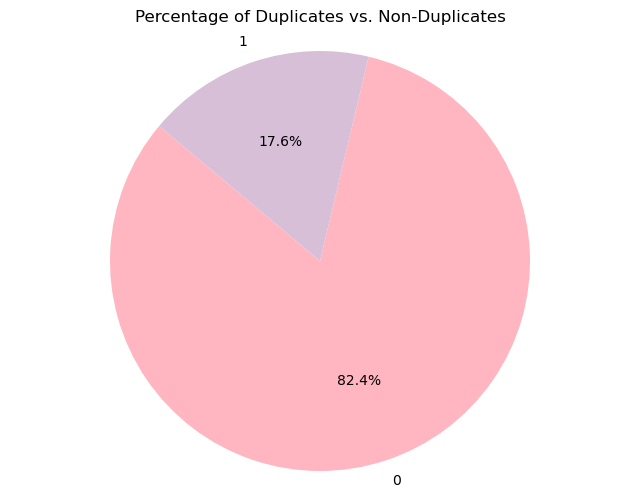

In [28]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [29]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_291979/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [30]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
1        Opening repository resource always open the de...
2        KM (10/2/2001 5:55:18 PM); \tThis PR about the...
3        - become synchronized with some project in a r...
4        For getting/setting the managed state of a res...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_291979/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_291979/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


# Sorting by time

In [31]:
print(df['Created_time'])

0        2001-10-10 21:34:00 -0400
1        2001-10-10 21:34:00 -0400
2        2001-10-10 21:34:00 -0400
3        2001-10-10 21:34:00 -0400
4        2001-10-10 21:34:00 -0400
                   ...            
68119    2008-05-01 09:47:00 -0400
68120    2008-05-01 09:52:00 -0400
68121    2008-05-01 10:05:00 -0400
68122    2008-05-01 11:02:00 -0400
68123    2008-05-01 11:20:00 -0400
Name: Created_time, Length: 68124, dtype: object


In [32]:
# Convert the 'Created_time' column to datetime
# Convert the 'Created_time' column to datetime with UTC
df['Created_time'] = pd.to_datetime(df['Created_time'], utc=True)

/tmp/ipykernel_291979/497475349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Created_time'] = pd.to_datetime(df['Created_time'], utc=True)


In [33]:
import pandas as pd

# Assuming df is your original DataFrame with 'Created_time' column already converted to datetime



# Create a 'Period' column to represent quarters
df['Period'] = df['Created_time'].dt.to_period('Q') 

# Group by quarters
period_groups = df.groupby('Period')

# List to store DataFrames for each quarter
quarterly_dfs = []
count=0
# Iterate over groups and append DataFrames to list
for i, (period, group_df) in enumerate(period_groups):
    quarterly_dfs.append(group_df)
    count=count+1

# Accessing each quarter's DataFrame:
# For example, to access the DataFrame for the first quarter:
print(quarterly_dfs[0])  # Index 0 corresponds to the first quarter DataFrame



      Issue_id Priority Component  Duplicated_issue  \
0            1       P3      Team               0.0   
1            2       P5      Team               0.0   
2            3       P5      Team               0.0   
3            4       P5      Team               0.0   
4            5       P3      Team               0.0   
...        ...      ...       ...               ...   
3218      7202       P3     Debug               0.0   
3219      7204       P3     Debug               0.0   
3220      7205       P5      Team               0.0   
3221      7207       P1     Debug               0.0   
3222      7208       P1     Debug               0.0   

                                                  Title  \
0       Usability issue with external editors (1GE6IRL)   
1     Opening repository resources doesnt honor type...   
2             Sync does not indicate deletion (1GIEN83)   
3     need better error message if catching up over ...   
4     ISharingManager sharing API inconsiste

/tmp/ipykernel_291979/4009835520.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Period'] = df['Created_time'].dt.to_period('Q')
/tmp/ipykernel_291979/4009835520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Period'] = df['Created_time'].dt.to_period('Q')


# Refactoring

### Creating functions to test with different parameters

In [34]:
def getDuplicateBugIDS(threshold_value,time_x_df): 
    import torch
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Encode sentences and store the embeddings in the DataFrame
    time_x_df['embeddings'] = time_x_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    # Convert embeddings to a tensor
    embeddings = torch.stack(time_x_df['embeddings'].tolist())
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    numpy_array = cosine_scores.numpy()
    # Reshape the NumPy array into a matrix
    similarity_Matrix= numpy_array.reshape(cosine_scores.shape)
    similarity_Matrix= np.round(similarity_Matrix, decimals=4)
    # Function to filter rows based on condition
    def filter_matrix(matrix, threshold):
        filtered_matrix = []
        for row in matrix:
            if np.any((row > threshold) & (row < 1)): #<1 to igorne the sim. with itself 
                filtered_matrix.append(row)
        return np.array(filtered_matrix)
    # Filtering the matrix
    filtered_matrix = filter_matrix(similarity_Matrix, threshold_value)
    n = 0 #to iterate through
    time_x_df['Experimental_Duplicate_ID'] = np.nan  #intailly sets everything to null
    while n < filtered_matrix.shape[0]:  # number of rows do this process to each row 
        matrix = filtered_matrix[n]
        def find_position(matrix):  # finds position (index) of bug all other bugs are comparing to
            result = np.where(matrix == 1.0)
            return result[0][0]  # Extract the first index directly
    
        def get_duplicate_ids_index(matrix):  # finds index where there are most similar bugs to the bug at find_position
            condition = np.logical_and(matrix > threshold_value, matrix < 1)
            indices = np.argwhere(condition)
            return indices
        def get_duplicate_ids(matrix_indexs_of_duplicates):
            duplicate_ids = ""
            for row in matrix_indexs_of_duplicates:
                for element in row:
                    specific_row = time_x_df.iloc[element]
                    duplicate_ids = duplicate_ids + " " + str(specific_row['Issue_id'])
            return duplicate_ids
        index_in_df = find_position(matrix)  # index of selected bug
        specific_row = time_x_df.iloc[index_in_df]  # selects bug row in dataframe
        duplicateIDs_index_in_df = get_duplicate_ids_index(matrix)  # index of duplicate bugs
        time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
        n += 1  # to go through each row in the matrix
    return time_x_df['Experimental_Duplicate_ID']

In [35]:
def accuracy(time_x_df):
    #a match is considered if there are any matching values in exp_ids and dup_ids 
       # Split the IDs by spaces and strip whitespace
    time_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = time_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = time_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    accuracy=num_matches/len(time_x_df)
    return accuracy

In [36]:
def precision(time_x_df):
    time_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = time_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = time_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()
    #falsePositive is when the experimental duplicate id has a number but the actual one doesn't
    falsePositives = ((time_x_df['Duplicated_issue'] == 0) & (time_x_df['Experimental_Duplicate_ID'] != 0)).sum()
    precison= truePositive/(truePositive+falsePositives)
    return precison
    

In [37]:
def recall(time_x_df):
    time_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = time_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = time_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches which is when the experiment and actual match aka true positive
    truePositive = matches.sum()

    # Convert columns to sets
    experimental_set = set(time_x_df['Experimental_Duplicate_ID'])
    actual_set = set(time_x_df['Duplicated_issue'])

    # Identify False Negatives
    falseNegatives = actual_set - experimental_set
    falseNegativesCount=len(list(falseNegatives))
    recall=truePositive/(truePositive+falseNegativesCount)
    return recall

In [38]:
def f1(time_x_df):
    recallVal=recall(time_x_df)
    precisonVal=precision(time_x_df)
    f1=2*((recallVal*precisonVal)/(precisonVal+recallVal))
    return f1

In [39]:
def experimentalisDuplicate(time_x_df): #creates column for experimental binary isDuplciates
    def is_duplicate(val):
        return 1 if val !=(0.0 or 0) else 0
    time_x_df['isExperimentalDuplicate'] = time_x_df['Experimental_Duplicate_ID'].apply(lambda x: is_duplicate(x))
    return time_x_df['isExperimentalDuplicate']

In [40]:
def binaryAccuracy(time_x_df): #see if the ones and zeros match, different from other acuracy becuase that one can have only one element mathc and it count ex bug 1 has ids 1234 and 8472 it should still count as a duplciate to bug 2 with 1234 0889 
    matches=time_x_df['isExperimentalDuplicate']==time_x_df['isDuplicate']
    num_matches=matches.sum()
    accuracy=num_matches/len(time_x_df['isExperimentalDuplicate'])
    return accuracy

# MORE refactoring

In [44]:

# Initialize lists to store the results
#for 85% similarity b
accuracy_values = []
binary_accuracy_values = []
recall_values = []
precision_values = []
f1_values = []
time_dfs=quarterly_dfs
for x in range(count): #counts is from when the dataframe was split into time 
    df = time_dfs[x]

    df['Experimental_Duplicate_ID'] = getDuplicateBugIDS(0.95, df)
    accuracyVal = accuracy(df) * 100
    accuracy_values.append(accuracyVal)
    print(f"Accuracy for topic {x} for matching id is %{accuracyVal:.2f}")

    experimentalisDuplicate(df)
    binaryAccuracyVal = binaryAccuracy(df) * 100
    binary_accuracy_values.append(binaryAccuracyVal)
    print(f"Accuracy for topic {x} for duplicate or not is %{binaryAccuracyVal:.2f}")

    recallVal = recall(df) * 100
    recall_values.append(recallVal)
    print(f"Recall for topic {x} is %{recallVal:.2f}")

    precisionVal = precision(df) * 100
    precision_values.append(precisionVal)
    print(f"Precision for topic {x} is %{precisionVal:.2f}")

    f1Val = f1(df) * 100
    f1_values.append(f1Val)
    print(f"F1 score for topic {x} is %{f1Val:.2f}")


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 0 for matching id is %90.32
Accuracy for topic 0 for duplicate or not is %90.32
Recall for topic 0 is %92.38
Precision for topic 0 is %99.52
F1 score for topic 0 is %95.82


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 1 for matching id is %88.01
Accuracy for topic 1 for duplicate or not is %88.01
Recall for topic 1 is %89.66
Precision for topic 1 is %100.00
F1 score for topic 1 is %94.55


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 2 for matching id is %83.06
Accuracy for topic 2 for duplicate or not is %83.06
Recall for topic 2 is %86.61
Precision for topic 2 is %100.00
F1 score for topic 2 is %92.83


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 3 for matching id is %84.44
Accuracy for topic 3 for duplicate or not is %84.44
Recall for topic 3 is %86.51
Precision for topic 3 is %100.00
F1 score for topic 3 is %92.77


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 4 for matching id is %80.74
Accuracy for topic 4 for duplicate or not is %80.74
Recall for topic 4 is %83.55
Precision for topic 4 is %100.00
F1 score for topic 4 is %91.04


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 5 for matching id is %80.28
Accuracy for topic 5 for duplicate or not is %80.28
Recall for topic 5 is %84.43
Precision for topic 5 is %100.00
F1 score for topic 5 is %91.56


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 6 for matching id is %78.62
Accuracy for topic 6 for duplicate or not is %78.62
Recall for topic 6 is %82.24
Precision for topic 6 is %100.00
F1 score for topic 6 is %90.26


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 7 for matching id is %80.29
Accuracy for topic 7 for duplicate or not is %80.29
Recall for topic 7 is %83.94
Precision for topic 7 is %100.00
F1 score for topic 7 is %91.27


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 8 for matching id is %77.59
Accuracy for topic 8 for duplicate or not is %77.59
Recall for topic 8 is %82.44
Precision for topic 8 is %100.00
F1 score for topic 8 is %90.37


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 9 for matching id is %77.58
Accuracy for topic 9 for duplicate or not is %77.58
Recall for topic 9 is %82.61
Precision for topic 9 is %100.00
F1 score for topic 9 is %90.48


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 10 for matching id is %78.14
Accuracy for topic 10 for duplicate or not is %78.14
Recall for topic 10 is %83.14
Precision for topic 10 is %100.00
F1 score for topic 10 is %90.80


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 11 for matching id is %80.67
Accuracy for topic 11 for duplicate or not is %80.67
Recall for topic 11 is %83.38
Precision for topic 11 is %100.00
F1 score for topic 11 is %90.93


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 12 for matching id is %81.86
Accuracy for topic 12 for duplicate or not is %81.86
Recall for topic 12 is %84.29
Precision for topic 12 is %100.00
F1 score for topic 12 is %91.48


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 13 for matching id is %83.99
Accuracy for topic 13 for duplicate or not is %83.99
Recall for topic 13 is %86.38
Precision for topic 13 is %100.00
F1 score for topic 13 is %92.69


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 14 for matching id is %83.64
Accuracy for topic 14 for duplicate or not is %83.64
Recall for topic 14 is %86.49
Precision for topic 14 is %100.00
F1 score for topic 14 is %92.75


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 15 for matching id is %80.92
Accuracy for topic 15 for duplicate or not is %80.92
Recall for topic 15 is %82.94
Precision for topic 15 is %100.00
F1 score for topic 15 is %90.68


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 16 for matching id is %83.73
Accuracy for topic 16 for duplicate or not is %83.73
Recall for topic 16 is %85.65
Precision for topic 16 is %100.00
F1 score for topic 16 is %92.27


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 17 for matching id is %84.35
Accuracy for topic 17 for duplicate or not is %84.35
Recall for topic 17 is %86.47
Precision for topic 17 is %100.00
F1 score for topic 17 is %92.75


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 18 for matching id is %81.21
Accuracy for topic 18 for duplicate or not is %81.21
Recall for topic 18 is %84.98
Precision for topic 18 is %100.00
F1 score for topic 18 is %91.88


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 19 for matching id is %78.90
Accuracy for topic 19 for duplicate or not is %78.90
Recall for topic 19 is %82.13
Precision for topic 19 is %100.00
F1 score for topic 19 is %90.19


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 20 for matching id is %83.23
Accuracy for topic 20 for duplicate or not is %83.23
Recall for topic 20 is %86.40
Precision for topic 20 is %100.00
F1 score for topic 20 is %92.70


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 21 for matching id is %85.29
Accuracy for topic 21 for duplicate or not is %85.29
Recall for topic 21 is %87.10
Precision for topic 21 is %100.00
F1 score for topic 21 is %93.11


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 22 for matching id is %86.00
Accuracy for topic 22 for duplicate or not is %86.00
Recall for topic 22 is %87.49
Precision for topic 22 is %100.00
F1 score for topic 22 is %93.33


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 23 for matching id is %82.48
Accuracy for topic 23 for duplicate or not is %82.48
Recall for topic 23 is %85.22
Precision for topic 23 is %100.00
F1 score for topic 23 is %92.02


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 24 for matching id is %85.19
Accuracy for topic 24 for duplicate or not is %85.19
Recall for topic 24 is %87.76
Precision for topic 24 is %100.00
F1 score for topic 24 is %93.48


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


Accuracy for topic 25 for matching id is %85.74
Accuracy for topic 25 for duplicate or not is %85.74
Recall for topic 25 is %87.78
Precision for topic 25 is %100.00
F1 score for topic 25 is %93.49


/home/claney/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy for topic 26 for matching id is %85.20
Accuracy for topic 26 for duplicate or not is %85.20
Recall for topic 26 is %86.29
Precision for topic 26 is %100.00
F1 score for topic 26 is %92.64


/tmp/ipykernel_291979/474897665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)


# Averages

In [45]:
import statistics
print(statistics.mean(accuracy_values))
print(statistics.mean(binary_accuracy_values))
print(statistics.mean(recall_values))
print(statistics.mean(precision_values))
print(statistics.mean(f1_values))

82.64709680189063
82.64709680189063
85.49167079176021
99.98227287116175
92.15260406985833


 # Visualizations

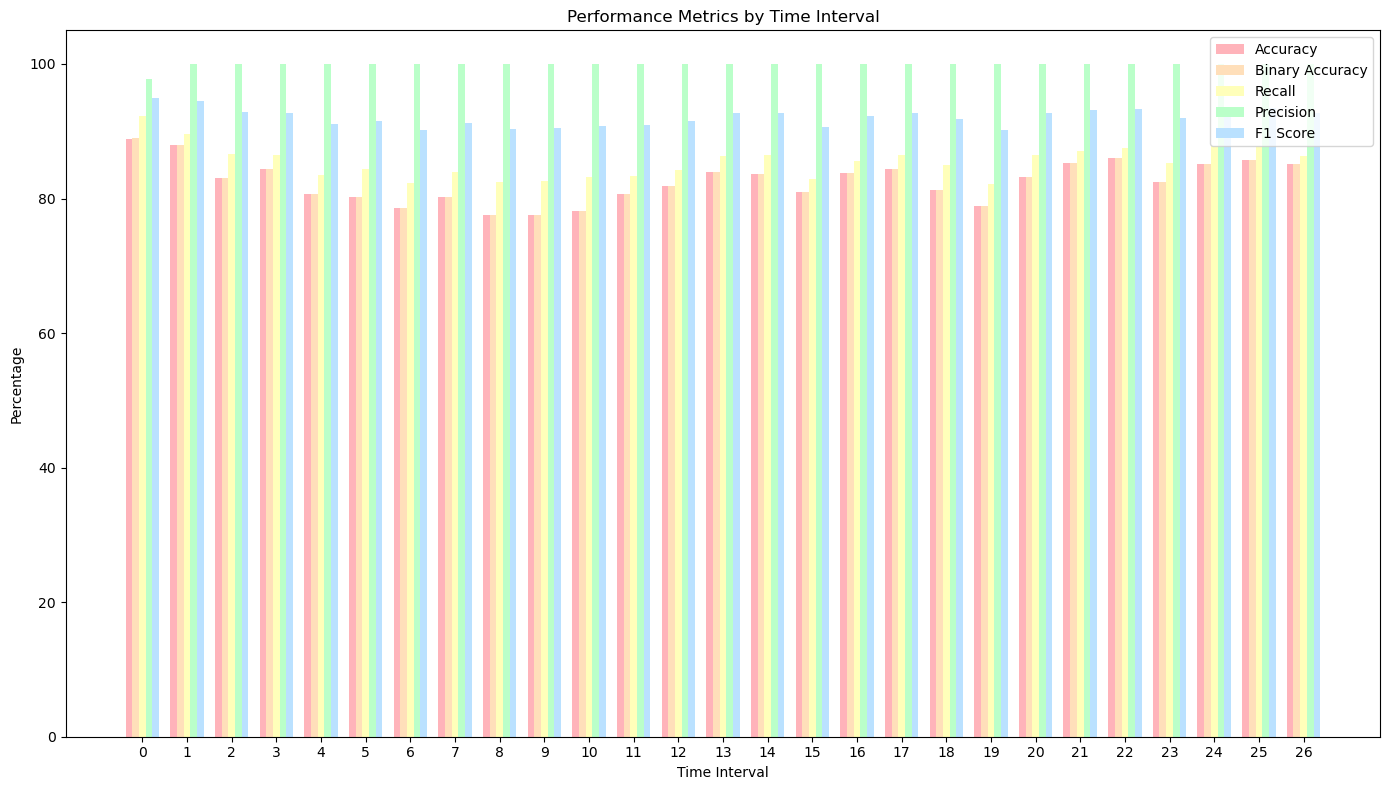

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of time intervals

# Define the time intervals (e.g., hours)
time_intervals = range(count)
bar_width = 0.15
index = np.arange(len(time_intervals))

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Define pastel rainbow colors
colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']

# Plot each set of values
bar1 = plt.bar(index, accuracy_values, bar_width, label='Accuracy', color=colors[0])
bar2 = plt.bar(index + bar_width, binary_accuracy_values, bar_width, label='Binary Accuracy', color=colors[1])
bar3 = plt.bar(index + 2 * bar_width, recall_values, bar_width, label='Recall', color=colors[2])
bar4 = plt.bar(index + 3 * bar_width, precision_values, bar_width, label='Precision', color=colors[3])
bar5 = plt.bar(index + 4 * bar_width, f1_values, bar_width, label='F1 Score', color=colors[4])

# Set labels, title, and legend
plt.xlabel('Time Interval')
plt.ylabel('Percentage')
plt.title('Performance Metrics by Time Interval')
plt.xticks(index + 2 * bar_width, time_intervals)
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
